# Benchmark for bayesian optimization

## Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/test_functions.py .
# !cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/bayes_lib.py .
# !pip install gpytorch
# !pip install botorch
from bayes_lib import ExactGPModel, train_hyper_params, get_x_new
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
import botorch
from botorch.test_functions.synthetic import Hartmann
from botorch.acquisition.analytic import ExpectedImprovement
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

## Define the ground truth, baseline and metric

In [2]:
def gt_func(x):
    """Ground truth function: negative hartmann 6
    The Bayes opt library we use aims to maximize functions by default.
    We use the negated function to effectively minimize it, i.e. argmin(f(x)) = argmax(-f(x))
    """
    hart = Hartmann()
    return - hart.evaluate_true(x)

def error_gap(current_best):
    """Returns the absolute difference between the global minimum of the hartmann 6 function
    and the current best value
            Error gap := |min f(x*) -  current best|
    """
    hart = Hartmann()
    return abs(current_best - (- hart.optimal_value))

def baseline_model(n_iter, n):
    """A model that attempts to minimize the error gap by picking n random sample and keeping the minimum value. 
    The process is repated over n_iter iterations
    Parameters
    ============
    n_iter: int
        number of iterations
    n: int
        number of samples drawn at each iteration
        
    Returns
    ============
    array of shape (n_iter,)
        contains the minimum error gaps
    """
    results = -np.ones(n_iter)
    best_result = error_gap(gt_func(torch.randn(n*6).reshape(-1,6)).max())

    for i in range(n_iter):
        best_result = min(best_result, error_gap(gt_func(torch.randn(n*6).reshape(-1,6)).max()))
        results[i] = best_result
    return results

## Run the Bayesian optimization

### Initialize

In [11]:
n_exp = 10                  # number of experiments
n_iter = 200                # number of iterations
print_period = 1           # results are printed every print_period iteration
n_train_ini = 20            # number of initial training examples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Model = ExactGPModel
likelihood = GaussianLikelihood(noise_constraint=Interval(0.0,1e-14)).to(device)

error_gaps = np.zeros([n_exp, n_iter]) # array to store the metrics

### Optimization loop

In [14]:
for i_exp in range(n_exp):
    # Initialize the experiment
    # ============================
    train_x = torch.rand(6*n_train_ini).reshape(-1,6).to(device)
    train_y = gt_func(train_x).to(device)
    best_f = train_y.max().item()
    for it in range(n_iter):
        # Run the forward model with hyperparam opt
        # ============================
        model = Model(train_x, train_y, likelihood).to(device)
        train_hyper_params(model, likelihood, training_iter=50)
        
        with torch.no_grad():
            # New point aquisition
            # ============================
            EI = ExpectedImprovement(model, best_f=best_f*0.1, maximize=True)
            x_new = get_x_new(EI, n_test=int(5e5), n_iter=3, refinement_fac = 1.5, device=device)
            y_new = gt_func(x_new).to(device)
            best_f = max(y_new.item(), best_f)

            train_x = torch.cat((train_x.reshape(-1,1), x_new.reshape(-1,1))).reshape(-1,6)
            train_y = torch.cat((train_y.reshape(-1,1), y_new.reshape(-1,1))).reshape(-1)

            # Print
            # ============================
            if (it+1)%print_period == 0:
                print(f"{it+1}/{n_iter}: {best_f:.5f}, {train_y[-1].item():.5f}, {np.log10(error_gap(best_f)):.5f}")
                
            # Record metric
            # ============================
            error_gaps[i_exp, it] = error_gap(best_f)
            
    # Save intermediate results
    # ============================        
    np.save("error_gaps", error_gaps)
    clear_output()

1/200: 0.60903, 0.01509, 0.43350
2/200: 0.60903, 0.04521, 0.43350
3/200: 0.60903, 0.03998, 0.43350
4/200: 0.60903, 0.52764, 0.43350
5/200: 0.60903, 0.01010, 0.43350
6/200: 0.60903, 0.02287, 0.43350
7/200: 0.60903, 0.00149, 0.43350
8/200: 0.60903, 0.00207, 0.43350


KeyboardInterrupt: 

# Plot

In [95]:
def plot_series(X, label=''):
    means = np.mean(X,0)
    stds = np.std(X,0)
    ax.plot(means, label=label)
    ax.fill_between(np.arange(n_iter), 
                    means + 2.0*stds, 
                    means - 2.0*stds, 
                    alpha=0.2)

In [121]:
baseline_results = np.array([baseline_model(n_iter, int(1e3)) for i in range(n_exp)])

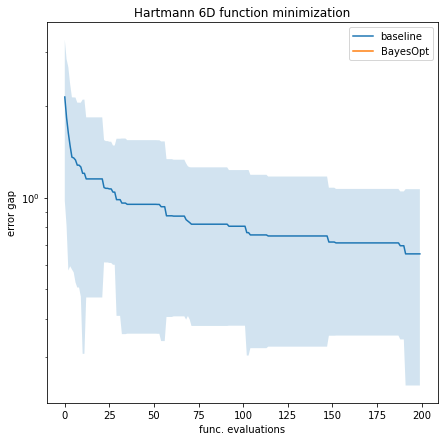

In [130]:
fig, ax = plt.subplots(1,1,figsize=[7,7])
plot_series(baseline_results, label='baseline')
plot_series(error_gaps, label='BayesOpt')
ax.set_yscale('log')
plt.legend()
plt.title("Hartmann 6D function minimization")
plt.ylabel("error gap")
plt.xlabel("func. evaluations")
plt.savefig("hartmann_min.png")

In [123]:
baseline_results

array([[2.59988403, 0.93611169, 0.93611169, ..., 0.6846261 , 0.6846261 ,
        0.6846261 ],
       [2.29379296, 2.09745026, 2.09745026, ..., 1.0429256 , 1.0429256 ,
        1.0429256 ],
       [2.68728805, 2.26617861, 2.26617861, ..., 0.427356  , 0.427356  ,
        0.427356  ],
       ...,
       [1.25964093, 1.25964093, 1.25964093, ..., 0.65661311, 0.65661311,
        0.65661311],
       [2.03850317, 2.03850317, 1.21541333, ..., 0.89540458, 0.89540458,
        0.89540458],
       [2.97160673, 2.16909742, 1.24568152, ..., 0.78744221, 0.78744221,
        0.78744221]])

1.1936148405075073